# ohsome green regions (via forest-related tags)

Welcome back to the ohsome region of the month format where you can learn and get inspiration about potential applications of the [ohsome API](https://api.ohsome.org/). This time we looked at forests, in four different Canadian regions (Edmonton, Halifax, Ottawa and Vancouver) looking for the green region of the month, which means there will be a winner announced at the end of this blog post. 
This time, the analysis will be done via jupyter notebook using the python programming language.

### **1. Data** 

As always there is no request without input information and, concerning the boundaries of the request, you can get a GeoJSON with region boundaries [here](https://osm-boundaries.com). This file will be used as spatial input to add the information of the boundaries of your request.


### **2: Import of libraries**

At first, you'll have to import libraries that will help you handle the data later on. This includes a range of things, being it sending the get/post request itself or plotting the output data.

_e.g.: numpy for stats, pandas for analytics or json for simply handling json-files as you will see further down in the code_

In [1]:
# import of useful libraries for the analysis (e.g. pandas -> analysis, 
# json -> for handling json responses)

import pandas as pd
import geopandas as gpd
import numpy as np
import json
import geojson
import requests
import plotly
import IPython
import matplotlib.pyplot as plt


# for generating interactive graphs
import plotly.graph_objs as go

from IPython.display import *
from geojson import MultiPolygon

plotly.offline.init_notebook_mode(connected=True)

### **3: Defining a function and the spatial & temporal boundaries**

Then you'll have to define the spatial and temporal boundaries of the request you intend to send. Begin by defining a variable for the ohsome API as well as a function to help building your request.
Below you will realize that two functions have been defined as there will be two different types of requests, quite similar to the ones sent in the [ohsome street network analysis](http://k1z.blog.uni-heidelberg.de/2021/01/18/ohsome-street-network-analysis-part-1/). But more information is to be found in the next step of this blog post.

In [2]:
#set a variable for the API
ohsome_api = "https://api.ohsome.org/v1"         

# define a functions for the filters
def elements(agg,**params):
    return requests.post(ohsome_api+"/elements"+agg,params)

def users(agg,**params):
    return requests.post(ohsome_api+"/users"+agg,params)

#define the spatial boundaries/set the path to your file:
with open("yourpath/marchregions.geojson") as f: 
    regions = json.load(f)
    regions = json.dumps(regions)

#define time intervals
t_mon = "2008-01-01/2021-02-01/P1M"
filter_req = '(landuse=forest or natural=wood) and geometry:polygon'


### **4: Requests**

The code below is dealing with how you can phrase your exact request. To keep it simple and get a first look at the data the request only asks for the overall density of wood/forest in the regions of interest.


For this months analysis you can request the data by using the following conditions:

For the forest dataset:

_endpoint	->	/elements/area/density/groupBy/boundary_

_timestamp  	->	2008-01-01/2021-02-01/P1M_

_filter		->	(landuse=forest or nature=wood) and geometry:polygon_


For the user dataset:

_endpoint		->	/users/groupBy/boundary_

_timestamp		->	2008-01-01/2021-02-01/P1M_

_filter		    ->	(landuse=forest or nature=wood) and geometry:polygon_



_-> You might wonder why there was only made use of forest-related tags but not of the tree key itself for this analysis. The problem was that said key wasn’t used because over the whole time span there was zero tree information given, yet, **BUT** at least for Ottawa a tree import has been [proposed in 2017](https://wiki.openstreetmap.org/wiki/Ottawa/Import/Trees) so there might be data for Ottawa soon! <-_

## **Analysis Part 1 - Density**

'https://api.ohsome.org/v1/elements/area/density/groupBy/boundary'

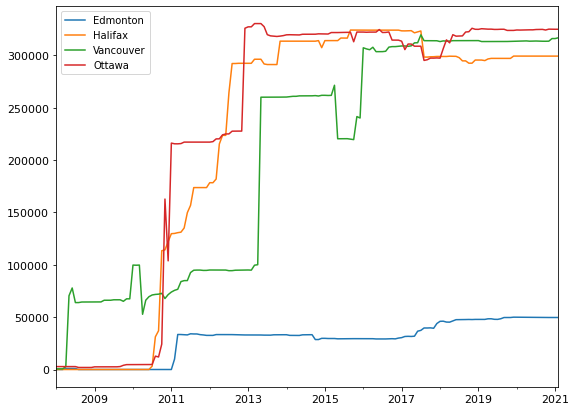

In [3]:
# define and plot request/path
def area():   
    res = elements("/area/density/groupBy/boundary"                 
         ,filter=filter_req
         ,bpolys=regions                                            
         ,time=t_mon)                                                
    display(res.url)
    green = res.json()
#turn output into DataFrame-format:
    df = pd.DataFrame()                                             
    for groupBy in green['groupByResult']:
        series = pd.Series({row['timestamp']:row['value'] for row in groupBy['result']})
        df[groupBy['groupByObject']] = series
    df.set_index(pd.to_datetime(df.index),inplace=True)
    df.to_pickle("./df_density.pkl")                                
    density = round(df, 2)
    density.plot(figsize=(9,7), fontsize=11)                            
area()

#### In the graphic above you can see the development of the density of natural=wood as well as landuse=forest information

When looking at the plot of the output dataset it is pretty safe to say that Edmonton has the lowest density of forest/wood information given when comparing it to the other regions. Although this might be part of low mapping activities too, it might as well be related to local oil and gas production areas or farmland which reduced the amount of forest. Another factor could be the general geographic connection to the Prairies Ecozone.

Furthermore, it is worth mentioning that all cities, but Vancouver, only really added their forest information around 2010 and 2011. 
Interestingly, the density-values for Vancouver only cross parts with the Ottawa- and Halifax-values around 2017. Additionally there is a strong increase in density in the early 2013 months. During that same year the Open Data Hackathon took place on Feb 23rd.

Ottawa and Halifax both begin to have increasing information starting around the same period in 2010 and cross each other several times until Ottawa finally takes its place at the top in 2018. Densitywise Ottawa is the winner looking at the overall development of density throughout the years. 

[Canvec imports](https://wiki.openstreetmap.org/wiki/CanVec) between 2010-2012 are might be related to the strong increases during that time period as the tag _natural=wood_ was part of the data given (-> CanVec Vegetation (VE)). Another related import might be one of [Canadian Protected Areas](https://wiki.openstreetmap.org/wiki/Import/Catalogue#One-Time_Imports) which has been in progress since 2009 ([from geogratis](http://geogratis.gc.ca)) but that is only an assumption.

,region,mean,median,min,max
0,Vancouver,204006.88,260064.90,614.07,319494.75
1,Halifax,223159.97,296758.98,0.00,324080.16
2,Edmonton,28518.29,32828.07,0.00,49962.98
3,Ottawa,234835.11,316338.05,1942.07,330267.47


<AxesSubplot:ylabel='region'>

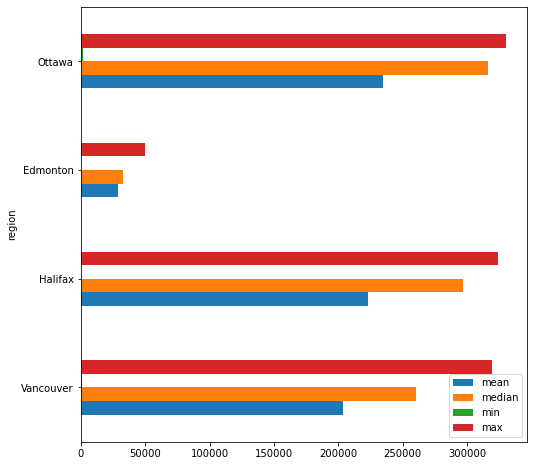

In [12]:
#read the pickle file which was saved earlier:
df_density = pd.read_pickle("./df_density.pkl")          

val = {'region':['Vancouver', 'Halifax', 'Edmonton', 'Ottawa'], 
       'mean': [204006.88, 223159.97, 28518.29, 234835.11], 
       'median': [260064.90, 296758.98, 32828.07, 316338.05], 'min':[614.07, 0.0, 0.0, 1942.07], 
       'max':[319494.75, 324080.16, 49962.98, 330267.47]}
val_density = pd.DataFrame(val)

display (val_density)
val_density.plot.barh(0, figsize=(8,8))

#The table was created by searching for the mean, median, minimum and maximum-values of each region.
#You can do it with numpy, like so:
#Ottawa, Ontario:
#Oarray = df_density['Ottawa']
#OttMean = np.mean(Oarray)
#OttMedian = np.median(Oarray)
#OttMin = np.min(Oarray)
#OttMax = np.max(Oarray)
#display(OttMean, OttMedian, OttMin, OttMax) -> to look at the values

#### Above you can see the output DataFrame 'val_density' with some statistics for the density dataset, below that it was visualized in a barchart.

Apart from Ottawa there is no display of a minimum value in the barchart above. This is due to the fact that Edmonton and Halifax both started at zero in the beginning of the examined timespan but also because the initial value of Metro Vancouver was probably too small to be visible in the graphic.

When looking at the chart one can once more see that Ottawa has the overall highest-density values when taking e.g. the mean or maximum-values into account, but even more so, it also has the highest initial (minimum) values!
It is followed by Halifax & Vancouver. Edmonton comes last with the smallest overall values.

,region,Δ density,percent
0,Vancouver,316130.09,0.998
1,Halifax,299203.41,1.000
2,Edmonton,49647.97,1.000
3,Ottawa,322071.36,0.991


<BarContainer object of 4 artists>

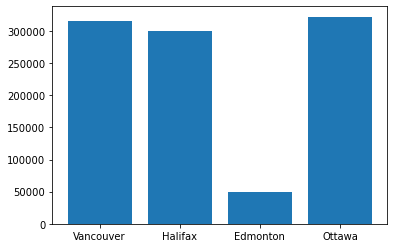

In [5]:
devdens = {'region':['Vancouver', 'Halifax', 'Edmonton', 'Ottawa'],
           'Δ density': [316130.09, 299203.41, 49647.97, 322071.36],
           'percent': [0.998, 1.0, 1.0, 0.991]}
dev_density = pd.DataFrame(devdens)

display (dev_density)

plt.figure()
x = dev_density['region']
y = dev_density['Δ density']
plt.bar(x,y)

#one way to calculate these values is:
#display(df_density)
#EdDiff = 49647.97 -  0.00
#EdPerc = EdDiff/49647.97
#display(EdDiff, EdPerc)

#### Above you can see the Δ density and percentual-values in numbers as well as figures. You can notice that the development for ALL regions was very good as the minimum percentuage of growth in density is in Ottawa with 99.143%.

As usual Edmonton shows the lowest values and Ottawa the highest. This is due to their overall development, yet it should be noted that the Δ density-values for Vancouver get really close to those of Ottawa and the starting values weren't much lower either which implies a very similar development over the whole timespan.

**Δ Density Ranking:**
1. Ottawa
2. Vancouver
3. Halifax
4. Edmonton

_side note: The percentage-values aren't shown in a figure as they are all very similar and differences were hard to make out with the eyes only_

## **Analysis Part 2 - Users**

'https://api.ohsome.org/v1/users/count/groupBy/boundary'

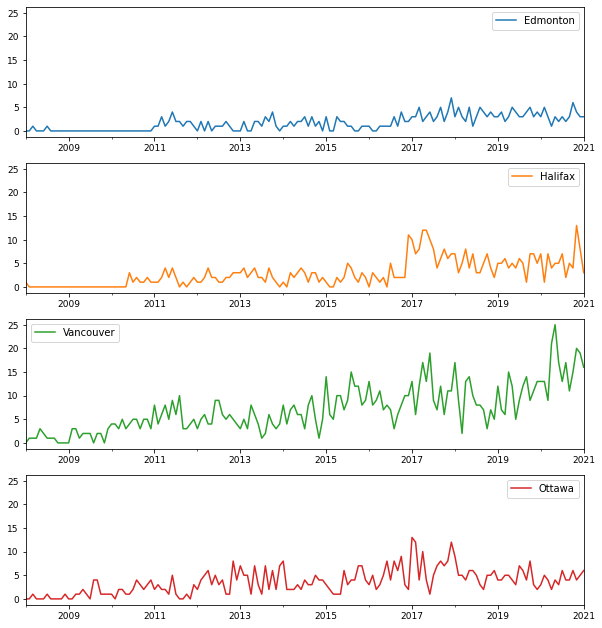

In [6]:
def groupBy():
    resU = users("/count/groupBy/boundary"
         ,filter=filter_req          
         ,bpolys=regions
         ,time=t_mon)
    display(resU.url)
    green_u = resU.json()
    #display(green_u)
    df = pd.DataFrame()
    for groupBy in green_u['groupByResult']:
        series = pd.Series({row['fromTimestamp']:row['value'] for row in groupBy['result']})
        df[groupBy['groupByObject']] = series
    df.set_index(pd.to_datetime(df.index),inplace=True)
    df.to_pickle("./df_users.pkl")
    df.plot(kind='line', subplots=True, sharex=False, sharey=True, figsize=(10,11), fontsize=9)
groupBy()

#### In the graphic above you can see the user numbers of the natural=wood as well as landuse=forest tag over the years

#### Edmonton:	  

Let's start from the top again.
There's almost no user activity from 2008 up until the end 2010. Notable user activity first starts around 2011 so at the same time as the main increase in density-values. One can observe that for certain time periods the user count keeps falling back to low or no user activity at all. Thhhe peak is reached by the end of 2017 but even after, there are still some quite high values. Furthermore, the peak also marks the time of the last notable increase in density information.


#### Halifax:	  

For the Halifax region there was nearly no user activity at all up until mid 2010 apart from a very short peak in the very beginning. The first peak in 2010 is in accord with the first strong density increase. However, after that the user numbers stay more or less on the same overall level until 2017 when they are peaking until about June of th same year which appears to be fitting the decreasing density-values around this time period either. There's one last peak in 2020.


#### Vancouver: 

For the Metro Vancouver region there are only very short timespans of complete user inactivity and an overall increasing trend is observable. The maximum user count is reached around Mid 2020 whilst the first density peak is at the same time as the first peak in user activity 2008. The increasing trend in user counts begins at around 2010, yet shortly after there is a fast decrease in density probably due to wrong or double values that were corrected. This might be related to the CanVec imports as one of the most important data sources.


#### Ottawa:    

In Ottawa there are three times of minor user activity until 2009 and subsequently an increasing trend until 2018 with times of lower user activity between 2014 and Mid 2015. The local mapping community also [mentions](https://wiki.openstreetmap.org/wiki/Ottawa#Status) that most of the info is from CanVec data.

,region,mean,median,min,max
0,Vancouver,7,6.0,0.0,25.0
1,Halifax,3,2.0,0.0,13.0
2,Edmonton,2,1.0,0.0,7.0
3,Ottawa,3,3.0,0.0,13.0


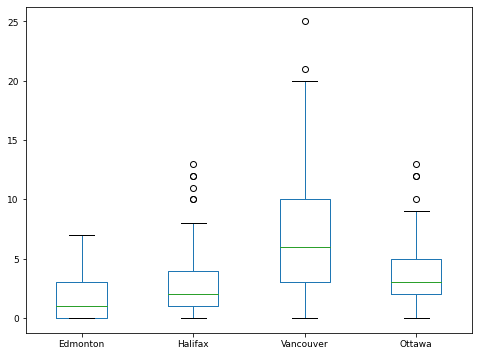

In [10]:
#read output dataset:
df_users = pd.read_pickle("./df_users.pkl")

val_u = {'region':['Vancouver', 'Halifax', 'Edmonton', 'Ottawa'], 
'mean': [7, 3, 2, 3], 
'median': [6.0, 2.0, 1.0, 3.0], 'min':[0.0, 0.0, 0.0, 0.0], 'max':[25.0, 13.0, 7.0, 13.0]}
val_users = pd.DataFrame(val_u)

df_users.plot(kind='box', figsize=(8,6), fontsize=9)
display (val_users)



#The table was again created by searching for the mean, median, minimum and maximum-values of each region.

When looking at the minimum value of the user data output, all the regions have the value 0, so during the observed time intervals, there were periods where no user performed any modification on features fitting to the analyzed filter. 
Again, Edmonton had the lowest values (mean, median & maximum), which might be yet another reason for the overall lower values in density of tree-related polygon-tags.

Halifax and Ottawa both have the same maximum value yet Ottawa is higher in mean as well as median. And the highest overall user-values are to be found for Vancouver.

**User activity Ranking:** 
1. Vancouver
2. Ottawa
3. Halifax
4. Edmonton

### Final Ranking:

Since both Vancouver & Ottawa made it to the top in one of the rankings it appears to be useful to announce 2 winners this time: Vancouver in terms of user counts and Ottawa in terms of overall density development.
This leaves us with following ranking:

1. Vancouver & Ottawa
2. Halifax
3. Edmonton


Thanks for reading this months blog post & additional notebook. Stay tuned for more notebooks and blog posts in the future!